In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import scipy
import statsmodels.api as s
from sklearn import metrics

import pdb

In [2]:
sub_list = ['AC_newepoch','AM', 'BB','CM','CR','GG','HA','IB','JM','JR','KK','KT','MC','MH','NF','SB','SG','SOG','TL','ZZ']
data_dir = f'/lab_data/behrmannlab/vlad/pepdoc/results_ex1' #read in the file; first value is the file name
curr_dir = f'/user_data/vayzenbe/GitHub_Repos/pepdoc' #CHANGE AS NEEEDED CAUSE ITS FOR VLAAAD
fig_dir = f'{curr_dir}/figures' #where to save the figures
results_dir = f'{curr_dir}/results' #where to save the results

# bin_size = 1 
categories = ['tool','nontool','bird','insect']
labels = np.asanyarray([0]*5 + [1]*5 + [2]*5 + [3]*5) #creates labels for data

#channels
channels = {'left_dorsal': [77, 78, 79, 80, 86, 87, 88, 89, 98, 99, 100, 110, 109, 118],
            'right_dorsal': [131, 143, 154, 163, 130, 142, 153, 162, 129, 141, 152, 128, 140, 127],
            'dorsal':  [77, 78, 79, 80, 86, 87, 88, 89, 98, 99, 100, 109, 110, 118] + [131, 143, 154, 163, 130, 142, 153, 162, 129, 141, 152, 128, 140, 127],
            'left_ventral':[104, 105, 106, 111, 112, 113, 114, 115, 120, 121, 122, 123, 133, 134],
            'right_ventral':[169, 177, 189, 159, 168, 176, 18, 199, 158, 167, 175, 187, 166, 174],
            'ventral': [104, 105, 106, 111, 112, 113, 114, 115, 120, 121, 122, 123, 133, 134] + [169, 177, 189, 159, 168, 176, 188, 199, 158, 167, 175, 187, 166, 174],
            'frontal': [11, 12, 18, 19, 20, 21, 25, 26, 27, 32, 33, 34, 37, 38],
            'occipital': [145,146,17,135,136,137,124,125,138,149,157,156,165]}




pre_stim = 50 #ms before stim onset
stim_end = 300 #ms when stim goes off
post_stim = 500 #ms after stim offset
bin_length = 4 #length of each bin in ms
bin_size = 1 #how many bins were averaged over; 1 = no averaging; 5 = average over 20 ms

#calculate start window for analysis given the bin size and length
start_window = pre_stim - (bin_length*(bin_size-1)) 
#calculate the onset point of the stimulus in the dataframe given the start window and bin length
stim_onset = int(start_window/bin_length)+1 
stim_offset = int(stim_end/bin_length)+stim_onset-1
timepoints = list(range(-start_window, post_stim, bin_length)) #134 4 ms bins


#### Granger causality

In [23]:
gca = pd.read_csv(f'{results_dir}/mvgca/mvgca_summary.csv')

<AxesSubplot:ylabel='dorsal_ventral'>

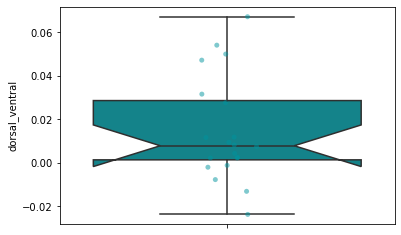

In [25]:
sns.boxplot(y=gca['dorsal_ventral'], color = '#00949e', notch=True)
 
# make grouped stripplot
sns.stripplot(y=gca['dorsal_ventral'], color = '#00949e',
              marker='o', 
              alpha=0.5)

#### Time generalized RSA analyses

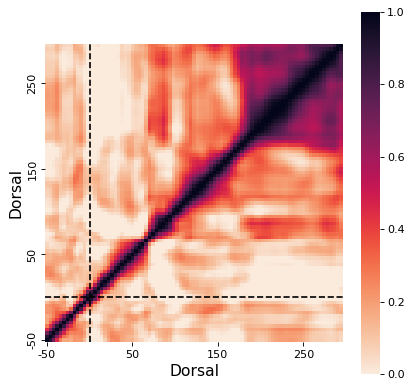

<Figure size 432x288 with 0 Axes>

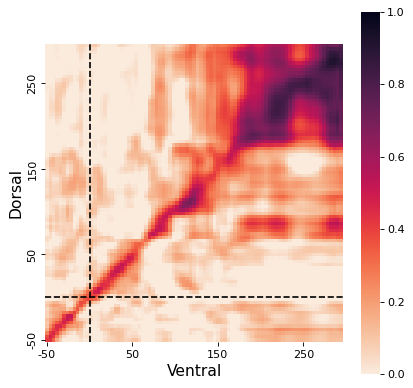

<Figure size 432x288 with 0 Axes>

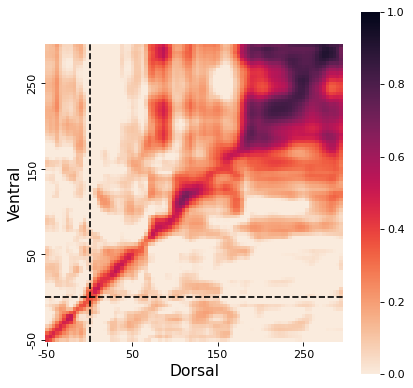

<Figure size 432x288 with 0 Axes>

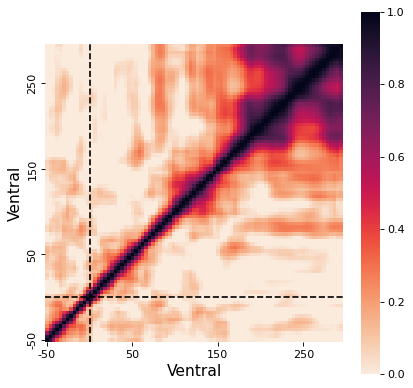

<Figure size 432x288 with 0 Axes>

In [54]:
"""
Plot time generalization using mean RDMs
"""

rois = ['dorsal','ventral']
#rois = ['dorsal']

#timepoints = np.asanyarray(timepoints)
time_cols = np.asanyarray(timepoints)
time_cols[1:] = time_cols[1:]
for roi1 in rois:
    for roi2 in rois:
        plt.figure(figsize=(6, 6), dpi=80)
        corr_ts = np.load(f'{results_dir}/rsa/{roi1}_{roi2}_corr_ts.npy')
        
        corr_df = pd.DataFrame(corr_ts, columns = time_cols, index = time_cols)
        corr_df = corr_df.iloc[:stim_offset,:stim_offset]
        ax = sns.heatmap(corr_df,xticklabels=25,yticklabels=25, vmin = 0, vmax = 1, square = True,
            cmap= "rocket_r")
        #ax.set_title(f'{roi1} {roi2}')
        ax.invert_yaxis()
        plt.axvline(13,  linestyle='--', color = 'black')
        plt.axhline(13,  linestyle='--', color = 'black')
        plt.ylabel(roi1.capitalize(), fontsize=14)
        plt.xlabel(roi2.capitalize(), fontsize=14)
        #cbar = ax.collections[0].colorbar
        #cbar.ax.tick_params(labelsize=12)
        #cbar.ax.clabel

        #ax.set(xticklabels=[])

        #ax.tick_params(bottom=False)  # remove the ticks
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        plt.show()
        plt.savefig(f'{fig_dir}/{roi1}_{roi2}_time_generalization.png', dpi=300)
    

In [56]:
"""
Time generalization diff on mean RDMs
"""

corr_ts = np.load(f'{results_dir}/rsa/dorsal_ventral_corr_ts.npy')
corr_ts = corr_ts[stim_onset:stim_offset,stim_onset:stim_offset]

corr_df = pd.DataFrame()
corr_df['corrs'] = corr_ts.flatten()

x_coord = []
y_coord = []
offset = []
label = []

inds = np.triu_indices(n=corr_ts.shape[0],k=1)
right_side = corr_ts[inds] #extract lower triangle
left_side = corr_ts[(inds[1],inds[0])] #extract upper triangle

for corr in corr_df['corrs']:
    if len(np.where(right_side == corr)[0]) == 1:
        label.append('Dorsal')
    if len(np.where(left_side == corr)[0]) == 1:
        label.append('Ventral')
    elif len(np.where(right_side == corr)[0]) == 0 and len(np.where(left_side == corr)[0]) == 0:
        label.append('Same')
    

    curr_x = np.where(corr_ts == corr)[0]
    curr_y = np.where(corr_ts == corr)[1]
    x_coord.append(curr_x)
    y_coord.append(curr_y)

    offset.append((curr_x- curr_y)*4)

corr_df['x_coord'] = x_coord
corr_df['y_coord'] = y_coord
corr_df['offset'] = offset
corr_df['label'] = label

corr_df.to_csv(f'{results_dir}/rsa/dorsal_ventral_corrs.csv')

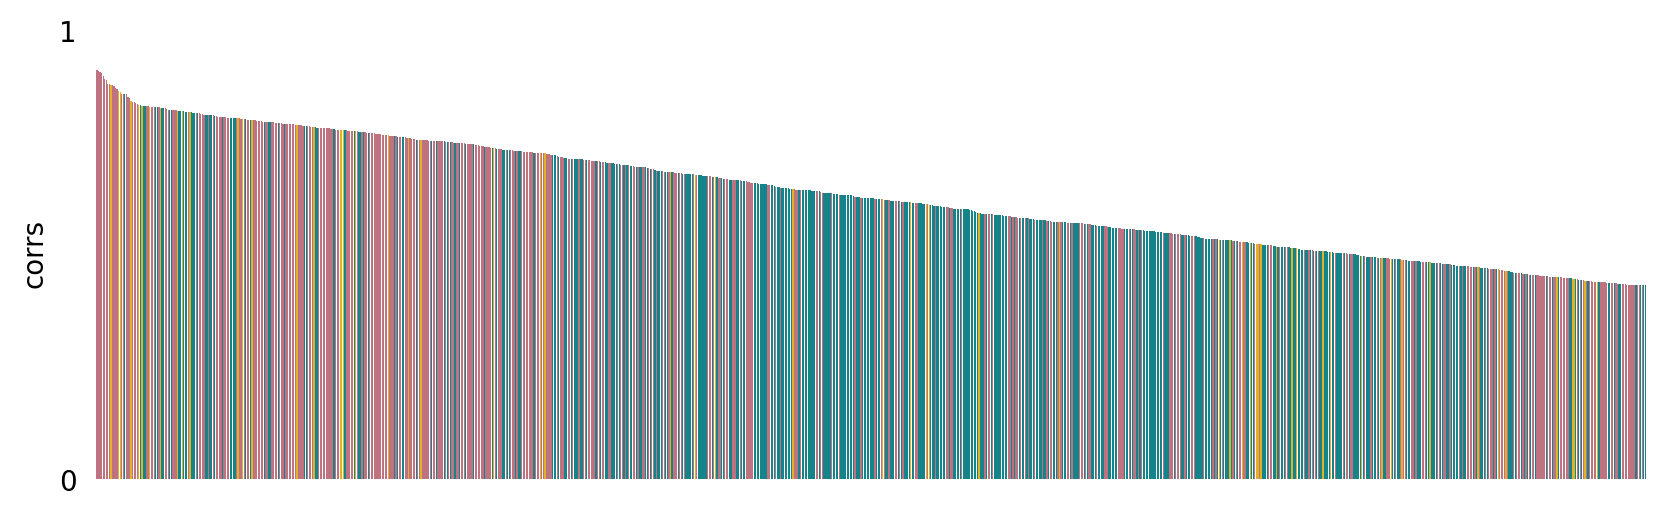

In [61]:
'''
Plot histogram of top correlations
'''
corr_df = pd.read_csv(f'{results_dir}/rsa/dorsal_ventral_corrs.csv')

corr_df = corr_df.sort_values(by='corrs', ascending=False)
corr_df = corr_df.reset_index()

vals = 1000
fig_df = corr_df.head(vals)

plt.figure(figsize=(10, 3), dpi=200)
sns.barplot(y=fig_df['corrs'], x = fig_df.index,order = fig_df.index, hue = fig_df['label'],dodge = False,
            palette = ['#CC6677','#FFC107','#00949e'])
ax = plt.gca()
ax.set(xticklabels=[])
ax.tick_params(bottom=False,left= False)  # remove the ticks
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)


#plt.ylabel('Correlation',fontsize=16)
#plt.axvline(onsets[roi[0]],  linestyle='--', color = colors[roi[0]])
#plt.yticks(np.arange(min(x), max(x)+1, 1.0))
#plt.xticks(fontsize= 14)
#plt.yticks(fontsize= 14)
plt.ylim(0,1.01)

ax = plt.gca()
#ax.xaxis.set_tick_params(width=1.5)
#ax.yaxis.set_tick_params(width=1.5)

start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(start, end, 1))

ax.get_legend().remove()


plt.savefig(f'{fig_dir}/correlation_hist_{vals}.png', dpi=300)

In [72]:
vals = np.arange(50,2050,50)

for val in vals:
    fig_df = corr_df.head(val)

    time_count = np.sum(fig_df['label'] == 'Dorsal')

    print(f'{time_count} out of {val}', time_count/ val, stats.binom_test(time_count,n=val, p= 0.49, alternative='two-sided'))
    

32 out of 50 0.64 0.04657324328729136
56 out of 100 0.56 0.16316538917791495
94 out of 150 0.6266666666666667 0.0010211600934461654
128 out of 200 0.64 2.64399695568903e-05
166 out of 250 0.664 3.9282067591700065e-08
198 out of 300 0.66 3.914506101385884e-09
225 out of 350 0.6428571428571429 1.1284876900573319e-08
246 out of 400 0.615 6.502273279660454e-07
264 out of 450 0.5866666666666667 4.7702337166306036e-05
276 out of 500 0.552 0.006304786666892036
290 out of 550 0.5272727272727272 0.08792586023797154
304 out of 600 0.5066666666666667 0.4145212516445828
322 out of 650 0.49538461538461537 0.7837910123656295
342 out of 700 0.48857142857142855 0.9698475413974452
357 out of 750 0.476 0.4651427596444704
370 out of 800 0.4625 0.12831207041056875
388 out of 850 0.45647058823529413 0.05059740283849208
408 out of 900 0.4533333333333333 0.02780474265606428
441 out of 950 0.46421052631578946 0.1192729863728948
471 out of 1000 0.471 0.24187508441043565
494 out of 1050 0.4704761904761905 0.216

In [68]:
"""
Test whether **MEAN** RDMs are right shifted or left shifted
"""
rois = ['dorsal','ventral']


#timepoints = np.asanyarray(timepoints)
time_cols = np.asanyarray(timepoints)
time_cols[1:] = time_cols[1:] + 2
df = pd.DataFrame()
for roi1 in rois:
    for roi2 in rois:
        if roi1 == roi2:
            continue
        else:
            corr_ts = np.load(f'{results_dir}/rsa/{roi1}_{roi2}_corr_ts.npy')
            corr_ts = corr_ts[stim_onset:stim_offset,stim_onset:stim_offset]

            #extract left and right sides of the diagnol
            inds = np.triu_indices(n=corr_ts.shape[0],k=1)
            right_side = corr_ts[inds] #extract lower triangle
            left_side = corr_ts[(inds[1],inds[0])] #extract upper triangle

            #calculate the difference between the left and right sides
            #if positive, then right shifted
            diff = right_side - left_side


            df[f'{roi1}_{roi2}'] = diff
            #left side rdm


df.to_csv(f'{results_dir}/rsa/mean_tga_diffs.csv', index = False)

In [70]:
np.mean(df['dorsal_ventral'])

0.01496259271891622

<AxesSubplot:>

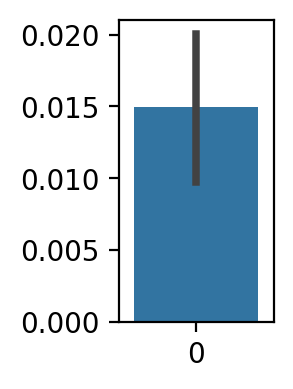

In [69]:


plt.figure(figsize=(1, 2), dpi=200)
sns.barplot(data = df['dorsal_ventral'])
#sns.violinplot(data = df['dorsal_ventral'], jitter=True, size=2, color='black')

In [71]:
"""
Test whether **INDIV** RDMs are right shifted or left shifted
"""
rois = ['dorsal','ventral']


#timepoints = np.asanyarray(timepoints)
time_cols = np.asanyarray(timepoints)
time_cols[1:] = time_cols[1:] + 2



df = pd.DataFrame()
df['subs'] = sub_list
for roi1 in rois:
    for roi2 in rois:
        if roi1 == roi2:
            continue
        else:
            sub_diffs =[]
            for sub in sub_list:
                corr_ts = np.load(f'{data_dir}/{sub}_{roi1}_{roi2}_corr_ts.npy')
                corr_ts = corr_ts[stim_onset:stim_offset,stim_onset:stim_offset]

                #extract left and right sides of the diagnol
                inds = np.triu_indices(n=corr_ts.shape[0],k=1)
                right_side = corr_ts[inds] #extract lower triangle
                left_side = corr_ts[(inds[1],inds[0])] #extract upper triangle

                #calculate the difference between the left and right sides
                #if positive, then right shifted
                diff = right_side - left_side


                
                #left side rdm

                sub_diffs.append(np.mean(diff))

            df[f'{roi1}_{roi2}'] = sub_diffs


df.to_csv(f'{results_dir}/rsa/indiv_tga_diffs.csv', index = False)

### TGM partial! correlations

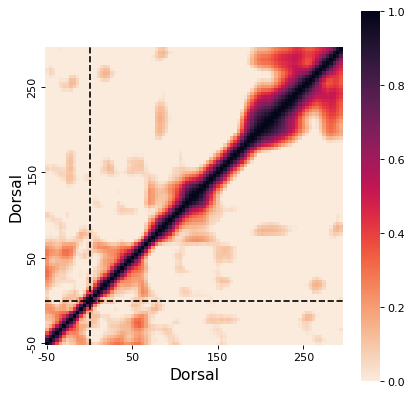

<Figure size 640x480 with 0 Axes>

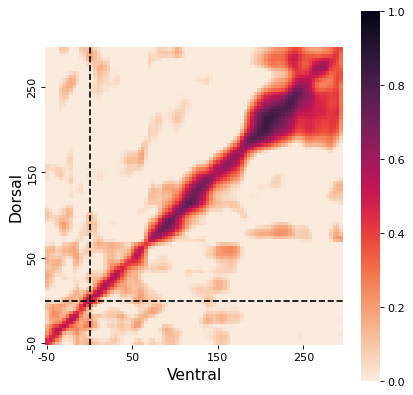

<Figure size 640x480 with 0 Axes>

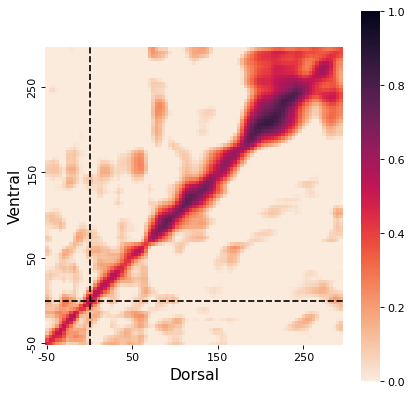

<Figure size 640x480 with 0 Axes>

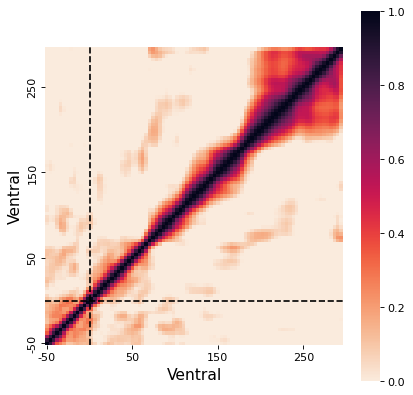

<Figure size 640x480 with 0 Axes>

In [3]:
"""
Plot time generalization using mean RDMs
"""

rois = ['dorsal','ventral']
#rois = ['dorsal']

#timepoints = np.asanyarray(timepoints)
time_cols = np.asanyarray(timepoints)
time_cols[1:] = time_cols[1:]
for roi1 in rois:
    for roi2 in rois:
        plt.figure(figsize=(6, 6), dpi=80)
        corr_ts = np.load(f'{results_dir}/rsa/{roi1}_{roi2}_partial_corr_ts.npy')
        
        corr_df = pd.DataFrame(corr_ts, columns = time_cols, index = time_cols)
        corr_df = corr_df.iloc[:stim_offset,:stim_offset]
        ax = sns.heatmap(corr_df,xticklabels=25,yticklabels=25, vmin = 0, vmax = 1, square = True,
            cmap= "rocket_r")
        #ax.set_title(f'{roi1} {roi2}')
        ax.invert_yaxis()
        plt.axvline(13,  linestyle='--', color = 'black')
        plt.axhline(13,  linestyle='--', color = 'black')
        plt.ylabel(roi1.capitalize(), fontsize=14)
        plt.xlabel(roi2.capitalize(), fontsize=14)
        #cbar = ax.collections[0].colorbar
        #cbar.ax.tick_params(labelsize=12)
        #cbar.ax.clabel

        #ax.set(xticklabels=[])

        #ax.tick_params(bottom=False)  # remove the ticks
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        plt.show()
        plt.savefig(f'{fig_dir}/{roi1}_{roi2}_partial_time_generalization.png', dpi=300)
    

In [4]:
"""
Time generalization diff on mean RDMs
"""

corr_ts = np.load(f'{results_dir}/rsa/dorsal_ventral_partial_corr_ts.npy')
corr_ts = corr_ts[stim_onset:stim_offset,stim_onset:stim_offset]

corr_df = pd.DataFrame()
corr_df['corrs'] = corr_ts.flatten()

x_coord = []
y_coord = []
offset = []
label = []

inds = np.triu_indices(n=corr_ts.shape[0],k=1)
right_side = corr_ts[inds] #extract lower triangle
left_side = corr_ts[(inds[1],inds[0])] #extract upper triangle

for corr in corr_df['corrs']:
    if len(np.where(right_side == corr)[0]) == 1:
        label.append('Dorsal')
    if len(np.where(left_side == corr)[0]) == 1:
        label.append('Ventral')
    elif len(np.where(right_side == corr)[0]) == 0 and len(np.where(left_side == corr)[0]) == 0:
        label.append('Same')
    

    curr_x = np.where(corr_ts == corr)[0]
    curr_y = np.where(corr_ts == corr)[1]
    x_coord.append(curr_x)
    y_coord.append(curr_y)

    offset.append((curr_x- curr_y)*4)

corr_df['x_coord'] = x_coord
corr_df['y_coord'] = y_coord
corr_df['offset'] = offset
corr_df['label'] = label

corr_df.to_csv(f'{results_dir}/rsa/dorsal_ventral_partial_corrs.csv')




In [5]:
corr_df.mean()

/tmp/ipykernel_2312/3621208955.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  corr_df.mean()


corrs       0.038781
x_coord    36.500000
y_coord    36.500000
offset      0.000000
dtype: float64

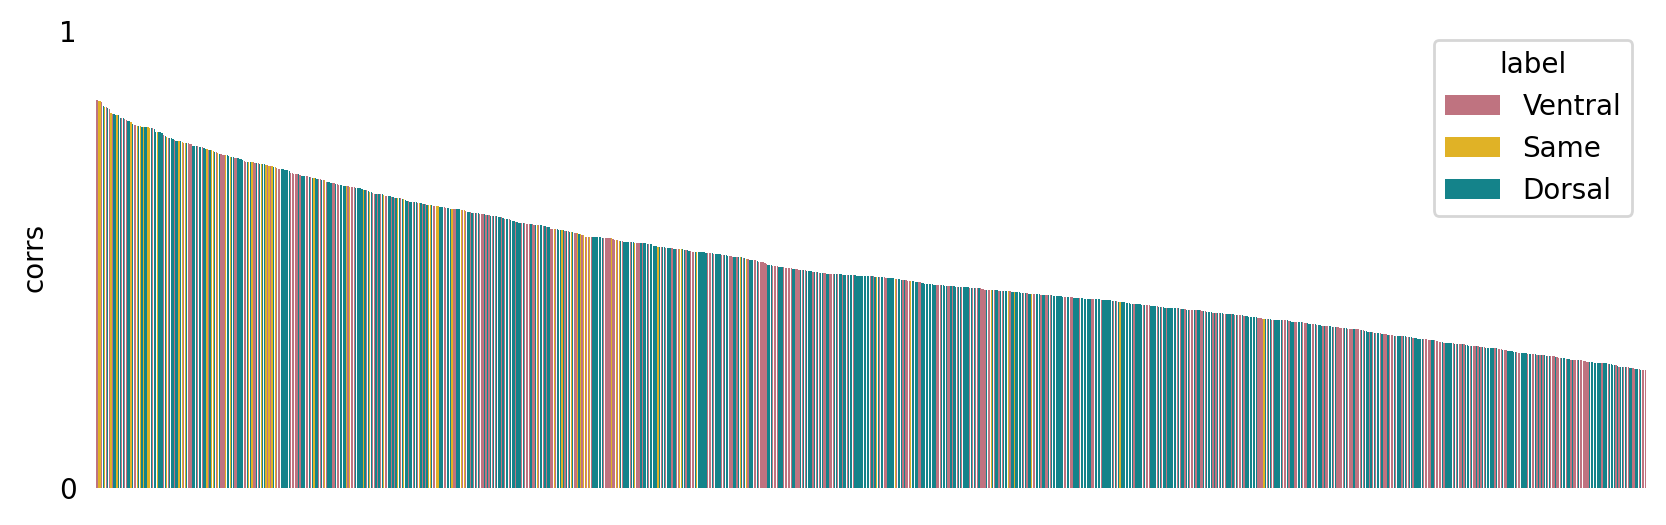

In [4]:
'''
Plot histogram of top correlations
'''

corr_df = pd.read_csv(f'{results_dir}/rsa/dorsal_ventral_partial_corrs.csv')

corr_df = corr_df.sort_values(by='corrs', ascending=False)
corr_df = corr_df.reset_index()

vals = 100
fig_df = corr_df.head(vals)

plt.figure(figsize=(10, 3), dpi=200)
sns.barplot(y=fig_df['corrs'], x = fig_df.index,order = fig_df.index, hue = fig_df['label'],dodge = False,
            palette = ['#CC6677','#FFC107','#00949e'])
ax = plt.gca()
ax.set(xticklabels=[])
ax.tick_params(bottom=False,left= False)  # remove the ticks
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)


#plt.ylabel('Correlation',fontsize=16)
#plt.axvline(onsets[roi[0]],  linestyle='--', color = colors[roi[0]])
#plt.yticks(np.arange(min(x), max(x)+1, 1.0))
#plt.xticks(fontsize= 14)
#plt.yticks(fontsize= 14)
plt.ylim(0,1.01)

ax = plt.gca()
#ax.xaxis.set_tick_params(width=1.5)
#ax.yaxis.set_tick_params(width=1.5)

start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(start, end, 1))

#ax.get_legend().remove()


plt.savefig(f'{fig_dir}/partial_correlation_hist_{vals}.png', dpi=300)

In [6]:
"""
Test whether **MEAN** RDMs are right shifted or left shifted
"""
rois = ['dorsal','ventral']


#timepoints = np.asanyarray(timepoints)
time_cols = np.asanyarray(timepoints)
time_cols[1:] = time_cols[1:] + 2
df = pd.DataFrame()
for roi1 in rois:
    for roi2 in rois:
        if roi1 == roi2:
            continue
        else:
            corr_ts = np.load(f'{results_dir}/rsa/{roi1}_{roi2}_partial_corr_ts.npy')
            corr_ts = corr_ts[stim_onset:stim_offset,stim_onset:stim_offset]

            #extract left and right sides of the diagnol
            inds = np.triu_indices(n=corr_ts.shape[0],k=1)
            right_side = corr_ts[inds] #extract lower triangle
            left_side = corr_ts[(inds[1],inds[0])] #extract upper triangle

            #calculate the difference between the left and right sides
            #if positive, then right shifted
            diff = right_side - left_side


            df[f'{roi1}_{roi2}'] = diff
            #left side rdm


df.to_csv(f'{results_dir}/rsa/mean_partial_tga_diffs.csv', index = False)

In [7]:
df.mean()

dorsal_ventral    0.036991
ventral_dorsal   -0.034135
dtype: float64

In [10]:
"""
Test whether **INDIV** partial RDMs are right shifted or left shifted
"""
rois = ['dorsal','ventral']


#timepoints = np.asanyarray(timepoints)
time_cols = np.asanyarray(timepoints)
time_cols[1:] = time_cols[1:] + 2



df = pd.DataFrame()
df['subs'] = sub_list
for roi1 in rois:
    for roi2 in rois:
        if roi1 == roi2:
            continue
        else:
            sub_diffs =[]
            for sub in sub_list:
                if os.path.isfile(f'{data_dir}/{sub}/{roi1}_{roi2}_partial_corr_ts.npy'):
                    corr_ts = np.load(f'{data_dir}/{sub}_{roi1}_{roi2}_partial_corr_ts.npy')
                    corr_ts = corr_ts[stim_onset:stim_offset,stim_onset:stim_offset]

                    #extract left and right sides of the diagnol
                    inds = np.triu_indices(n=corr_ts.shape[0],k=1)
                    right_side = corr_ts[inds] #extract lower triangle
                    left_side = corr_ts[(inds[1],inds[0])] #extract upper triangle

                    #calculate the difference between the left and right sides
                    #if positive, then right shifted
                    diff = right_side - left_side


                    
                    #left side rdm

                    sub_diffs.append(np.mean(diff))

            df[f'{roi1}_{roi2}'] = sub_diffs


df.to_csv(f'{results_dir}/rsa/indiv_partial_tga_diffs.csv', index = False)

ValueError: Length of values (0) does not match length of index (20)

In [11]:
sub_diffs

[]